In [959]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Import the activities

In [960]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

def get_token():
    response = requests.post(
                        url = 'https://www.strava.com/oauth/token',
                        data = {
                                'client_id': '[YOUR_CLIENT_ID]',
                                'client_secret': '[YOUR_CLIENT_SECRET]',
                                'refresh_token': '[YOUR_REFRESH_TOKEN]',
                                'code': '[YOUR_AUTHORIZATION_CODE]',
                                'grant_type': 'refresh_token'
                                }
                    )
    access_token = response.json()['access_token']
    print(access_token)
    return access_token

def get_activities(access_token, from_date, to_date):
    url = f'https://www.strava.com/api/v3/athlete/activities?after={from_date}&before={to_date}&page=1&per_page=200'
    payload={}
    headers = {
        'Authorization': 'Bearer ' + access_token
        }
    response = requests.request("GET", url, headers=headers, data=payload)
    activities = response.json()
    return activities

def get_kudos(access_token, activity_id):
    url = f'https://www.strava.com/api/v3/activities/{activity_id}/kudos?page=1&per_page=200'
    payload={}
    headers = {
        'Authorization': 'Bearer ' + access_token
        }
    response = requests.request("GET", url, headers=headers, data=payload)
    data = response.json()
    return data

def transform(access_token, activities):
    for act in activities:
        if act["private"] == False:
            activity_id = act['id']
            nb_kudos = act['kudos_count']
            #kudos_list = [item['firstname'] + ' ' + item['lastname']  for item in get_kudos(access_token, activity_id)]
            distance = act['distance']
            moving_time = act['moving_time']
            sport_type = act['sport_type']
            total_elevation_gain = act['total_elevation_gain']
            start_date_local = act['start_date_local']
            average_speed = act['average_speed']
            suffer_score = act['suffer_score']
            if act['has_heartrate'] == True:
                average_heartrate = act['average_heartrate']
            else:
                average_heartrate = None

            stats = {
                'activity_id' : activity_id,
                'nb_kudos' : nb_kudos,
                #'kudos_list': kudos_list,
                'distance': distance,
                'moving_time': moving_time,
                'sport_type': sport_type,
                'total_elevation_gain': total_elevation_gain,
                'start_date_local': start_date_local,
                'average_speed': average_speed,
                'average_heartrate': average_heartrate,
                'suffer_score': suffer_score
            }
            statlist.append(stats)
    return

def to_1D(series):
    return pd.Series([x for list in series for x in list]) #series of lists to list of elements

In [961]:
# Get access token
access_token = get_token()

# Define the from date and to date
from_date = datetime(2022, 1, 1) #datetime(year, month, day)
from_date = int(from_date.timestamp()) #epoch of from_date
to_date = datetime(2022, 12, 31) #datetime(year, month, day)
to_date = int(to_date.timestamp()) #epoch of to_date

# Get activities in scope
activities = get_activities(access_token, from_date, to_date)

# Put the relevant data in a Dataframe
statlist = []
transform(access_token, activities)
df = pd.DataFrame(statlist)

In [962]:
# Add a date and month column for further use
df['date'] = df['start_date_local'].apply(pd.to_datetime, format='%Y-%m-%d').dt.date
df['month'] = df['start_date_local'].apply(pd.to_datetime, format='%Y-%m-%d').dt.month
df = df.sort_values(by="start_date_local")
df.head()

,activity_id,nb_kudos,distance,moving_time,sport_type,total_elevation_gain,start_date_local,average_speed,average_heartrate,suffer_score,date,month
54,6455205724,7,4800.6,1589,Run,6.1,2022-01-01T12:37:07Z,3.021,164.7,62.0,2022-01-01,1
53,6635652530,11,49516.6,8161,Ride,442.4,2022-02-05T14:26:41Z,6.067,NaN,351.0,2022-02-05,2
52,6745119897,6,6753.2,2321,Run,10.9,2022-02-27T11:13:28Z,2.910,167.9,107.0,2022-02-27,2
51,6788573623,12,10861.0,3527,Run,14.4,2022-03-07T18:44:12Z,3.079,140.9,112.0,2022-03-07,3
50,6816517211,11,36252.1,5490,Ride,254.7,2022-03-13T10:18:00Z,6.603,147.3,112.0,2022-03-13,3


### RUNS

#### Let's look at the runs - Distance over the months - Data prep

In [963]:
# Get all the runs distance and suffer score by month
runs = df[df['sport_type'] == 'Run'][['date', 'suffer_score', 'distance']] 
runs = (runs.set_index('date')
  .reindex(pd.date_range('2022-01-01', '2022-12-31', freq='D')) # to have every day in the dataframe
  .rename_axis(['date'])
  .fillna(0)
  .reset_index())

df_runs_mth = runs.groupby([pd.Grouper(key='date', freq='MS')])[['suffer_score', 'distance']].sum().reset_index().sort_values('date') # group by month

In [964]:
average_runs = df_runs_mth['distance'].mean()
under_average_runs = df_runs_mth[df_runs_mth['distance']<average_runs]
over_average_runs = df_runs_mth[df_runs_mth['distance']>=average_runs]

#### Plot the data

In [965]:
def bar_plot(original_data, low_series, high_series, average):
    # Setup plot size
    fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
    
    # Colors
    colors_high = ["#e5383b","#660708"]
    colors_low = ["#f5f3f4","#b1a7a6"]
    # Colormap
    cmap_low = mpl.colors.LinearSegmentedColormap.from_list("my color", colors_low, N=256)
    cmap_high = mpl.colors.LinearSegmentedColormap.from_list("my color", colors_high, N=256)
    norm_low = mpl.colors.Normalize(low_series['distance'].min(), average)
    norm_high = mpl.colors.Normalize(average, high_series['distance'].max())

    # Plot bars and average (horizontal) line
    bar1 = ax.bar(low_series['date'], low_series['distance'], color=cmap_low(norm_low(low_series['distance'])), width=20, label='Below Average', zorder=2)
    bar2 = ax.bar(high_series['date'], high_series['distance'], color=cmap_high(norm_high(high_series['distance'])), width=20, label='Above Average', zorder=2)
    plt.axhline(y=average, color = 'grey', linewidth=3)
    #ax.text(x=0.12, y=0.8, s="Average", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    
    # Determine the y-limits of the plot
    ymin, ymax = ax.get_ylim()
    # Calculate a suitable y position for the text label
    y_pos = average/ymax + 0.03
    # Annotate the average line
    ax.text(0.98, y_pos, f'Average = {average/1000:.2f} km', ha='right', va='center', transform=ax.transAxes, size=8, zorder=3)

    

    # Create grid 
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    # Remove splines
    ax.spines[['top','right','bottom']].set_visible(False)

    # Make left spine slightly thicker
    ax.spines['left'].set_linewidth(1.1)

    # Add label on top of each bar
    #rects = ax.patches
    #for rect in rects:
     #   height = rect.get_height()
      #  ax.text(rect.get_x() + rect.get_width() / 2, height + 1, int(height), ha='center', va='bottom', size=10) 
    
    # Add label on top of each bar - alternative
    ax.bar_label(bar1, labels=[f'{e/1000:,.2f}' for e in low_series['distance']], padding=3, color='black', fontsize=8)    
    ax.bar_label(bar2, labels=[f'{e/1000:,.2f}' for e in high_series['distance']], padding=3, color='black', fontsize=8)    

    # Add in red line and rectangle on top
    ax.plot([0.12, .9],                  # Set width of line
        [.98, .98],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
    ax.add_patch(plt.Rectangle((0.12,.98),          # Set location of rectangle by lower left corder
                        0.04,                       # Width of rectangle
                        -0.02,                      # Height of rectangle. Negative so it goes down.
                        facecolor='#E3120B', 
                        transform=fig.transFigure, 
                        clip_on=False, 
                        linewidth = 0))
    
    # Add legend
    ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8)

    # Reformat x-axis tick labels
    ax.xaxis.set_tick_params(labelsize=12) # Set tick label size
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Set rotation of labels
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(original_data['date'], labels) # Add labels to x-ticks

    # Reformat yaxis
    ax.set_ylabel('Distance', fontsize=12, labelpad=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_major_formatter(lambda s, i : f'{s/1e3:,.0f} km')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_tick_params(pad=-2,        # Pad tick labels so they don't go over y-axis
                        labeltop=True,      # Put x-axis labels on top
                        labelbottom=False,  # Set no x-axis labels on bottom
                        bottom=False,       # Set no ticks on bottom
                        labelsize=12)       # Set tick label size                  

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s="Strava Stats 2022 - Runs", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s="Number of km run each month from 01/01/2022 to 31/12/2022", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
    
    # Adjust the margins around the plot area
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
    
    # Export plot as high resolution PNG
    plt.savefig('strava_2022_runs.png', bbox_inches="tight", facecolor='white', pad_inches=0.5)
    
    plt.show()

    return

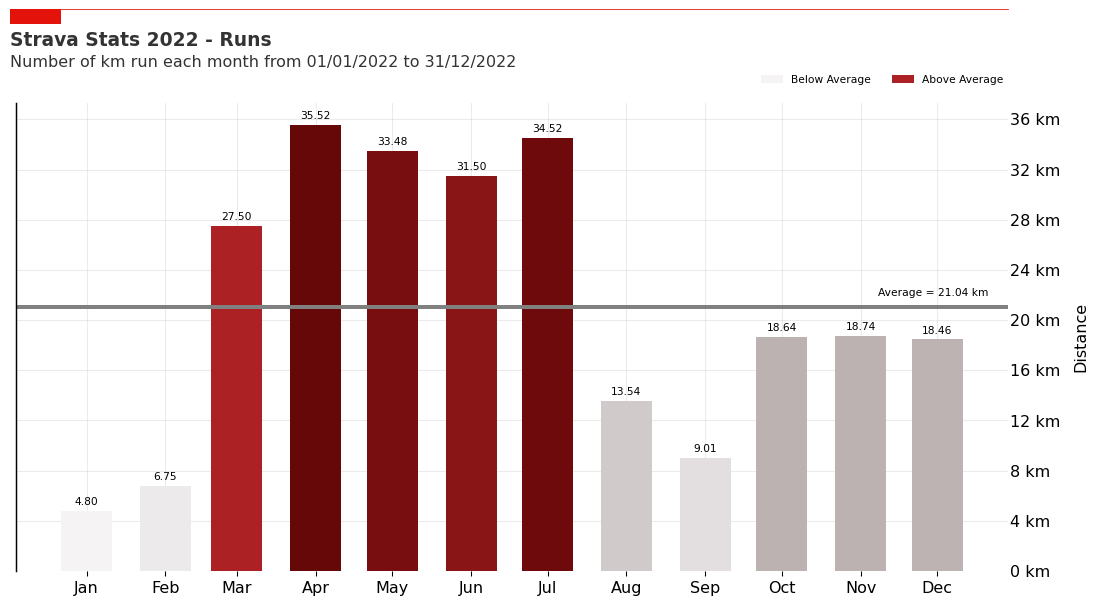

In [966]:
bar_plot(original_data=df_runs_mth, low_series=under_average_runs, high_series=over_average_runs, average=average_runs)

### RIDES

#### Let's look at the Rides - Distance over the months

In [967]:
# Get all the rides distance and suffer score by month
rides = df[df['sport_type'] == 'Ride'][['date', 'suffer_score', 'distance']]
rides = (rides.set_index('date')
  .reindex(pd.date_range('2022-01-01', '2022-12-31', freq='D')) # to have every day in the dataframe
  .rename_axis(['date'])
  .fillna(0)
  .reset_index())

df_rides_mth = rides.groupby([pd.Grouper(key='date', freq='MS')])[['suffer_score', 'distance']].sum().reset_index().sort_values('date') # group by month

In [968]:
average_rides = df_rides_mth['distance'].mean()
under_average_rides = df_rides_mth[df_rides_mth['distance']<average_rides]
over_average_rides = df_rides_mth[df_rides_mth['distance']>=average_rides]

#### Plot the data

In [969]:
def bar_plot(original_data, low_series, high_series, average):
    # Setup plot size
    fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
    
    # Colors
    colors_high = ["#fff3b0","#e09f3e"]
    colors_low = ["#415a77","#778da9"]
    # Colormap
    cmap_low = mpl.colors.LinearSegmentedColormap.from_list("my color", colors_low, N=256)
    cmap_high = mpl.colors.LinearSegmentedColormap.from_list("my color", colors_high, N=256)
    norm_low = mpl.colors.Normalize(low_series['distance'].min(), average)
    norm_high = mpl.colors.Normalize(average, high_series['distance'].max())

    # Plot bars and average (horizontal) line
    bar1 = ax.bar(low_series['date'], low_series['distance'], color=cmap_low(norm_low(low_series['distance'])), width=20, label='Below Average', zorder=2)
    bar2 = ax.bar(high_series['date'], high_series['distance'], color=cmap_high(norm_high(high_series['distance'])), width=20, label='Above Average', zorder=2)
    plt.axhline(y=average, color = 'grey', linewidth=3)
    #ax.text(x=0.12, y=0.8, s="Average", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    
    # Determine the y-limits of the plot
    ymin, ymax = ax.get_ylim()
    # Calculate a suitable y position for the text label
    y_pos = average/ymax + 0.03
    # Annotate the average line
    ax.text(0.98, y_pos, f'Average = {average/1000:.2f} km', ha='right', va='center', transform=ax.transAxes, size=8, zorder=3)

    

    # Create grid 
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    # Remove splines
    ax.spines[['top','right','bottom']].set_visible(False)

    # Make left spine slightly thicker
    ax.spines['left'].set_linewidth(1.1)

    # Add label on top of each bar
    #rects = ax.patches
    #for rect in rects:
     #   height = rect.get_height()
      #  ax.text(rect.get_x() + rect.get_width() / 2, height + 1, int(height), ha='center', va='bottom', size=10) 
    
    # Add label on top of each bar - alternative
    ax.bar_label(bar1, labels=[f'{e/1000:,.2f}' for e in low_series['distance']], padding=3, color='black', fontsize=8)    
    ax.bar_label(bar2, labels=[f'{e/1000:,.2f}' for e in high_series['distance']], padding=3, color='black', fontsize=8)    

    # Add in red line and rectangle on top
    ax.plot([0.12, .9],                  # Set width of line
        [.98, .98],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
    ax.add_patch(plt.Rectangle((0.12,.98),          # Set location of rectangle by lower left corder
                        0.04,                       # Width of rectangle
                        -0.02,                      # Height of rectangle. Negative so it goes down.
                        facecolor='#E3120B', 
                        transform=fig.transFigure, 
                        clip_on=False, 
                        linewidth = 0))
    
    # Add legend
    ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8)

    # Reformat x-axis tick labels
    ax.xaxis.set_tick_params(labelsize=12) # Set tick label size
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Set rotation of labels
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(original_data['date'], labels) # Add labels to x-ticks

    # Reformat yaxis
    ax.set_ylabel('Distance', fontsize=12, labelpad=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_major_formatter(lambda s, i : f'{s/1e3:,.0f} km')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_tick_params(pad=-2,        # Pad tick labels so they don't go over y-axis
                        labeltop=True,      # Put x-axis labels on top
                        labelbottom=False,  # Set no x-axis labels on bottom
                        bottom=False,       # Set no ticks on bottom
                        labelsize=12)       # Set tick label size                  

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s="Strava Stats 2022 - Rides", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s="Number of km cycled each month from 01/01/2022 to 31/12/2022", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
    
    # Adjust the margins around the plot area
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
    
    # Export plot as high resolution PNG
    plt.savefig('strava_2022_rides.png', bbox_inches="tight", facecolor='white', pad_inches=0.5)
    
    plt.show()

    return

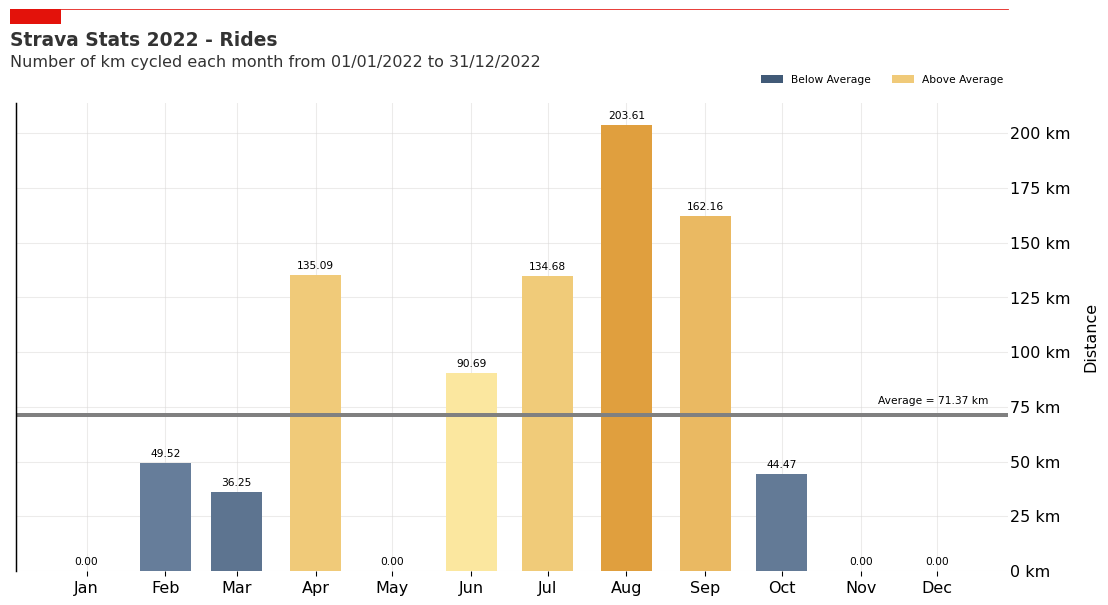

In [970]:
bar_plot(original_data=df_rides_mth, low_series=under_average_rides, high_series=over_average_rides, average=average_rides)

### RUNS & RIDES

#### In order to compare have both on the same graph, let's use the suffer score

In [971]:
# Get all the runs and rides suffer score by month
runs_rides = df[(df['sport_type'] == 'Run') | (df['sport_type'] == 'Ride')][['date', 'suffer_score', 'distance']]
runs_rides = (runs_rides.set_index('date')
  .reindex(pd.date_range('2022-01-01', '2022-12-31', freq='D')) # to have every day in the dataframe
  .rename_axis(['date'])
  .fillna(0)
  .reset_index())

df_runs_rides_mth = runs_rides.groupby([pd.Grouper(key='date', freq='MS')])[['suffer_score', 'distance']].sum().reset_index().sort_values('date') # group by month

In [972]:
average_rr = df_runs_rides_mth['suffer_score'].mean()
under_average_rr = df_runs_rides_mth[df_runs_rides_mth['suffer_score']<average_rr]
over_average_rr = df_runs_rides_mth[df_runs_rides_mth['suffer_score']>=average_rr]

#### Plot the data

In [973]:
def bar_plot_suffer_score(original_data, low_series, high_series, average):
    # Setup plot size
    fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
    
    # Colors
    colors_high = ["#f7b267","#e36414"]
    colors_low = ["#2196f3","#bbdefb"]
    # Colormap
    cmap_low = mpl.colors.LinearSegmentedColormap.from_list("my color", colors_low, N=256)
    cmap_high = mpl.colors.LinearSegmentedColormap.from_list("my color", colors_high, N=256)
    norm_low = mpl.colors.Normalize(low_series['suffer_score'].min(), average)
    norm_high = mpl.colors.Normalize(average, high_series['suffer_score'].max())

    # Plot bars and average (horizontal) line
    bar1 = ax.bar(low_series['date'], low_series['suffer_score'], color=cmap_low(norm_low(low_series['suffer_score'])), width=20, label='Below Average', zorder=2)
    bar2 = ax.bar(high_series['date'], high_series['suffer_score'], color=cmap_high(norm_high(high_series['suffer_score'])), width=20, label='Above Average', zorder=2)
    plt.axhline(y=average, color = 'grey', linewidth=3)
    #ax.text(x=0.12, y=0.8, s="Average", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    
    # Determine the y-limits of the plot
    ymin, ymax = ax.get_ylim()
    # Calculate a suitable y position for the text label
    y_pos = average/ymax + 0.03
    # Annotate the average line
    ax.text(0.98, y_pos, f'Average = {average:.0f}', ha='right', va='center', transform=ax.transAxes, size=8, zorder=3)

    # Create grid 
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    # Remove splines
    ax.spines[['top','right','bottom']].set_visible(False)

    # Make left spine slightly thicker
    ax.spines['left'].set_linewidth(1.1)

    # Add label on top of each bar
    #rects = ax.patches
    #for rect in rects:
     #   height = rect.get_height()
      #  ax.text(rect.get_x() + rect.get_width() / 2, height + 1, int(height), ha='center', va='bottom', size=10) 
    
    # Add label on top of each bar - alternative
    ax.bar_label(bar1, labels=[f'{e:,.0f}' for e in low_series['suffer_score']], padding=3, color='black', fontsize=8)    
    ax.bar_label(bar2, labels=[f'{e:,.0f}' for e in high_series['suffer_score']], padding=3, color='black', fontsize=8)    

    # Add in red line and rectangle on top
    ax.plot([0.12, .9],                  # Set width of line
        [.98, .98],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
    ax.add_patch(plt.Rectangle((0.12,.98),          # Set location of rectangle by lower left corder
                        0.04,                       # Width of rectangle
                        -0.02,                      # Height of rectangle. Negative so it goes down.
                        facecolor='#E3120B', 
                        transform=fig.transFigure, 
                        clip_on=False, 
                        linewidth = 0))
    
    # Add legend
    ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8)

    # Reformat x-axis tick labels
    ax.xaxis.set_tick_params(labelsize=12) # Set tick label size
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Set rotation of labels
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(original_data['date'], labels) # Add labels to x-ticks

    # Reformat yaxis
    ax.set_ylabel('Suffer Score', fontsize=12, labelpad=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_tick_params(pad=-2,        # Pad tick labels so they don't go over y-axis
                        labeltop=True,      # Put x-axis labels on top
                        labelbottom=False,  # Set no x-axis labels on bottom
                        bottom=False,       # Set no ticks on bottom
                        labelsize=12)       # Set tick label size                  

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s="Strava Stats 2022 - Runs and Rides", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s="Suffer score each month from 01/01/2022 to 31/12/2022", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
    
    # Adjust the margins around the plot area
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
    
    # Export plot as high resolution PNG
    plt.savefig('strava_2022_runs&rides.png', bbox_inches="tight", facecolor='white', pad_inches=0.5)
    
    plt.show()

    return

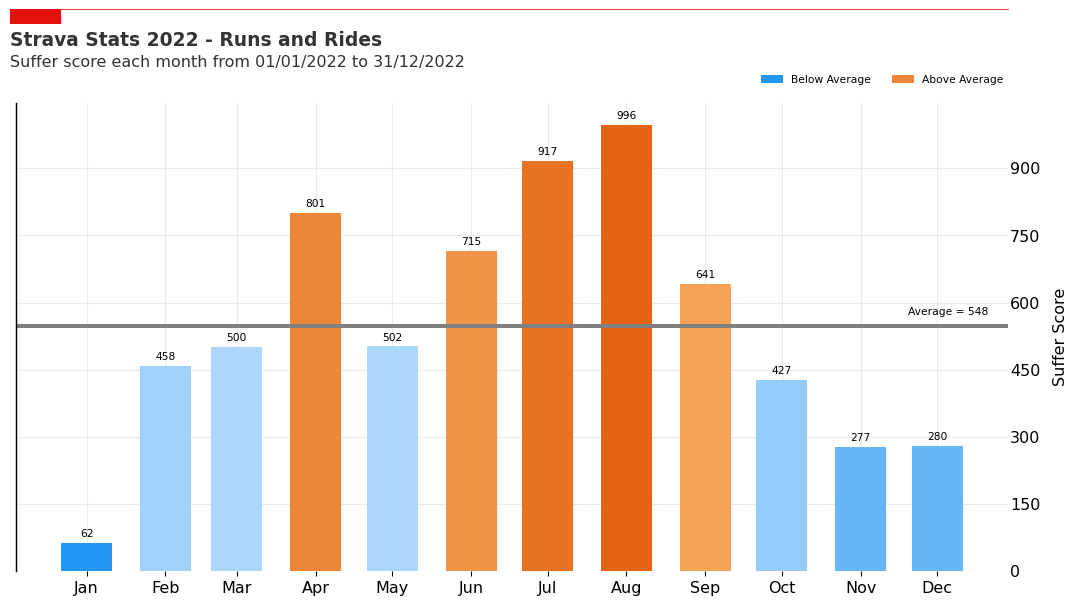

In [974]:
bar_plot_suffer_score(original_data=df_runs_rides_mth, low_series=under_average_rr, high_series=over_average_rr, average=average_rr)

#### Split between rides and runs

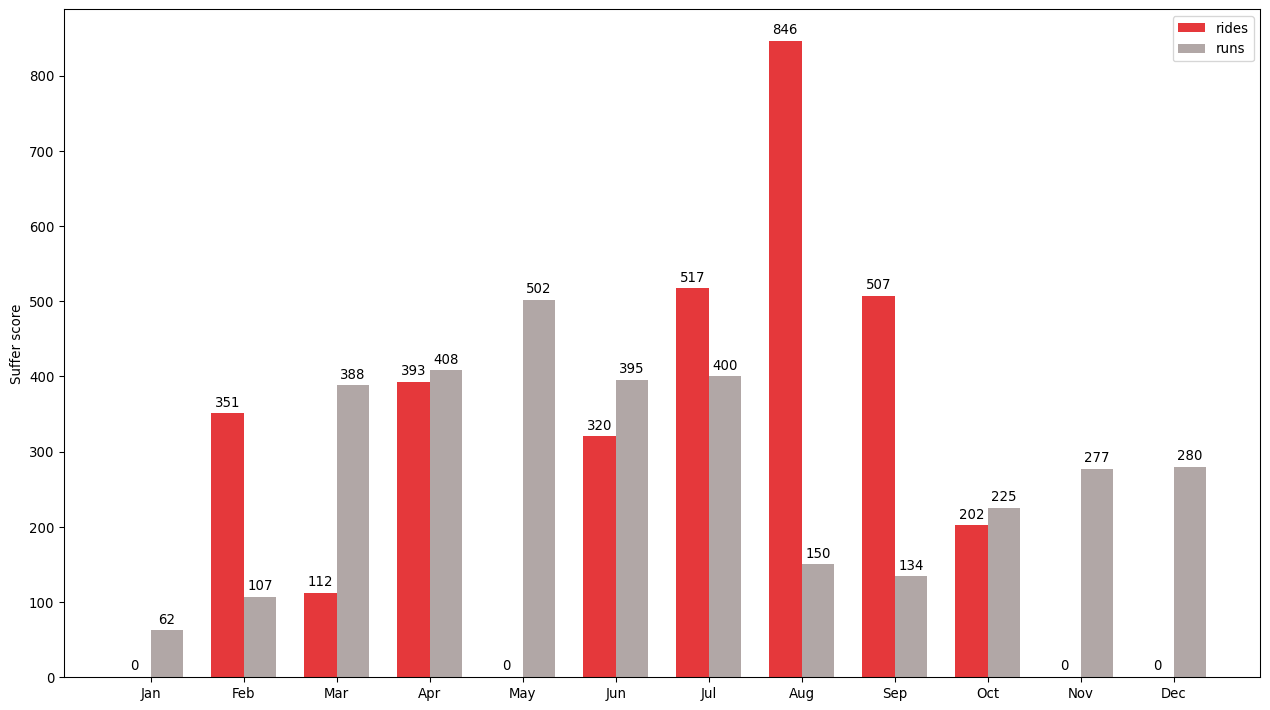

In [975]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rides = ax.bar(x - width/2, df_rides_mth['suffer_score'], width, label='rides', color='#e5383b')
runs = ax.bar(x + width/2, df_runs_mth['suffer_score'], width, label='runs', color='#b1a7a6')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Suffer score')
ax.set_xticks(x, labels)

ax.legend()

ax.bar_label(rides, padding=3)
ax.bar_label(runs, padding=3)

fig.tight_layout()

In [976]:
# From raw value to percentage
totals = [i+j for i,j in zip(df_runs_mth['suffer_score'], df_rides_mth['suffer_score'])]
runs_prop = [i / j * 100 for i,j in zip(df_runs_mth['suffer_score'], totals)]
rides_prop = [i / j * 100 for i,j in zip(df_rides_mth['suffer_score'], totals)]

In [987]:
def bar_plot_suffer_score_stacked(original_data, bar1, bar2):
    # Setup plot size
    fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)

    # Plot bars and average (horizontal) line
    width = 20
    runs = ax.bar(df_runs_mth['date'], runs_prop, color='#b1a7a6', width=width, label='runs', alpha=0.7, zorder=2)
    rides = ax.bar(df_rides_mth['date'], rides_prop, bottom=runs_prop, color='#415a77', edgecolor='white', width=width, label='rides', alpha=0.7, zorder=2)    

    # Create grid 
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    # Remove splines
    ax.spines[['top','right','bottom']].set_visible(False)

    # Make left spine slightly thicker
    ax.spines['left'].set_linewidth(1.1)

    # Add label on top of each bar
    #rects = ax.patches
    #for rect in rects:
     #   height = rect.get_height()
      #  ax.text(rect.get_x() + rect.get_width() / 2, height + 1, int(height), ha='center', va='bottom', size=10) 
    
    # Add label on top of each bar - alternative
    ax.bar_label(runs, labels=[f'{e:,.0f}%' for e in runs_prop], padding=3, color='black', fontsize=8, label_type='center')    
    ax.bar_label(rides, labels=[f'{e:,.0f}%' for e in rides_prop], padding=3, color='black', fontsize=8, label_type='center')    

    # Add in red line and rectangle on top
    ax.plot([0.12, .9],                  # Set width of line
        [.98, .98],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
    ax.add_patch(plt.Rectangle((0.12,.98),          # Set location of rectangle by lower left corder
                        0.04,                       # Width of rectangle
                        -0.02,                      # Height of rectangle. Negative so it goes down.
                        facecolor='#E3120B', 
                        transform=fig.transFigure, 
                        clip_on=False, 
                        linewidth = 0))
    
    # Add legend
    ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8)

    # Reformat x-axis tick labels
    ax.xaxis.set_tick_params(labelsize=12) # Set tick label size
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Set rotation of labels
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(original_data['date'], labels) # Add labels to x-ticks

    # Reformat yaxis
    ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.0f}%')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_tick_params(pad=-2,        # Pad tick labels so they don't go over y-axis
                        labeltop=True,      # Put x-axis labels on top
                        labelbottom=False,  # Set no x-axis labels on bottom
                        bottom=False,       # Set no ticks on bottom
                        labelsize=12)       # Set tick label size                  

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s="Strava Stats 2022 - Runs and Rides", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s="Suffer score proportion each month from 01/01/2022 to 31/12/2022", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
    
    # Adjust the margins around the plot area
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
    
    # Export plot as high resolution PNG
    plt.savefig('strava_2022_split_runs_rides.png', bbox_inches="tight", facecolor='white', pad_inches=0.5)
    
    plt.show()

    return

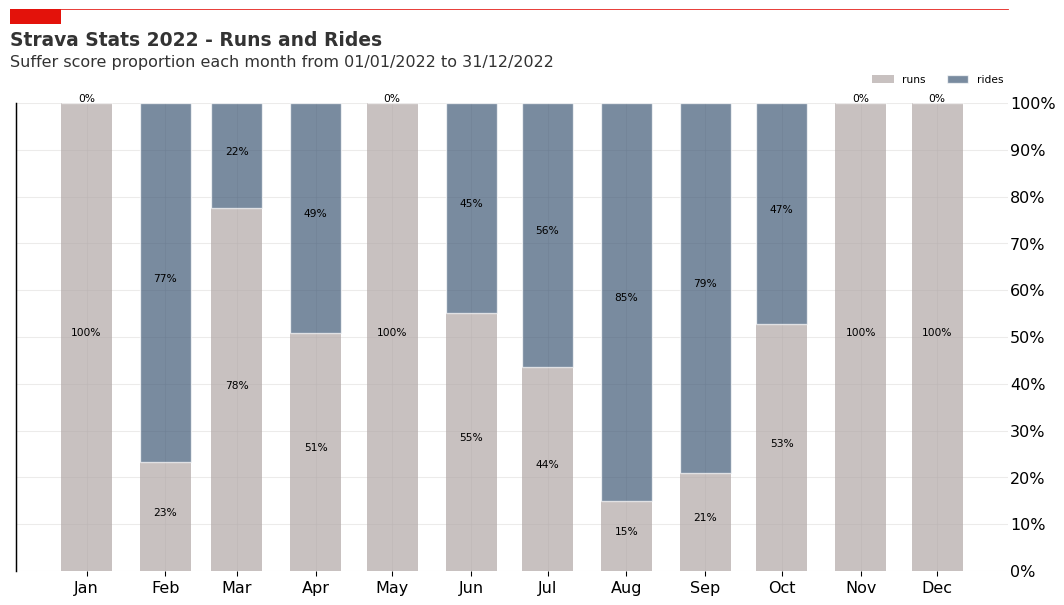

In [988]:
bar_plot_suffer_score_stacked(df_runs_rides_mth, df_runs_mth, df_rides_mth)

### Typical activity

#### Runs

In [989]:
runs = df[df['sport_type'] == 'Run'][['suffer_score', 'distance', 'moving_time', 'nb_kudos', 'total_elevation_gain', 'average_speed', 'average_heartrate']] 

In [990]:
runs["average_heartrate"] = runs["average_heartrate"].fillna(150)
runs['dummy'] = 1

In [991]:
runs.describe()

,suffer_score,distance,moving_time,nb_kudos,total_elevation_gain,average_speed,average_heartrate,dummy
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,118.857143,9016.503571,2947.357143,12.214286,21.589286,3.083571,163.203571,1.0
std,34.754924,2207.356759,765.219175,3.083494,21.130149,0.279098,9.119149,0.0
min,40.000000,4800.600000,1452.000000,6.000000,6.100000,2.277000,140.900000,1.0
25%,99.750000,7261.050000,2338.000000,10.750000,13.275000,2.985250,160.200000,1.0
50%,115.500000,9129.900000,2973.500000,12.500000,15.900000,3.095500,165.150000,1.0
75%,147.000000,10288.300000,3338.750000,14.000000,19.750000,3.266250,168.100000,1.0
max,181.000000,13537.800000,4603.000000,19.000000,103.300000,3.547000,176.900000,1.0


#### Rides

In [992]:
rides = df[df['sport_type'] == 'Ride'][['sport_type', 'suffer_score', 'distance', 'moving_time', 'nb_kudos', 'total_elevation_gain', 'average_speed', 'average_heartrate']] 

In [993]:
rides["average_heartrate"] = rides["average_heartrate"].fillna(150)
rides['dummy'] = 2

In [994]:
rides.describe()

,suffer_score,distance,moving_time,nb_kudos,total_elevation_gain,average_speed,average_heartrate,dummy
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0
mean,191.058824,50380.952941,8163.764706,14.647059,624.417647,6.264235,147.664706,2.0
std,87.924307,16775.654333,2943.028107,4.372373,434.744234,0.756075,6.855193,0.0
min,78.000000,36073.300000,5490.000000,9.000000,138.100000,4.538000,134.200000,2.0
25%,136.000000,41277.800000,6700.000000,11.000000,256.800000,5.673000,145.300000,2.0
50%,174.000000,49516.600000,7426.000000,15.000000,508.100000,6.359000,148.500000,2.0
75%,206.000000,52134.200000,8105.000000,16.000000,940.400000,6.811000,152.600000,2.0
max,364.000000,110063.000000,17646.000000,23.000000,1754.500000,7.384000,157.600000,2.0


#### Suffer score comparison

In [997]:
def scatter_plot(runs, rides):
    # Setup plot size
    fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)

    # Plot bars and average (horizontal) line
    width = 20
    size_runs = runs['distance']/13
    runs_graph = ax.scatter(runs['suffer_score'], runs['dummy'], color='#b1a7a6', zorder=2, alpha=0.3, s=size_runs)
    size_rides = rides['distance']/13
    rides_graph = ax.scatter(rides['suffer_score'], rides['dummy'], color='#415a77', zorder=2, alpha=0.3, s=size_rides)
    runs_mean = ax.scatter(runs['suffer_score'].mean(), runs['dummy'].iloc[0], color='red', label = 'mean', marker='X', zorder=2, alpha=1, s=100)
    rides_mean = ax.scatter(rides['suffer_score'].mean(), rides['dummy'].iloc[0], color='red', marker='X', zorder=2, alpha=1, s=100)
    
    # Annotate the categories
    ax.text(1.05, 0.75, 'Rides', ha='right', va='center', transform=ax.transAxes, size=12, zorder=3)
    ax.text(1.05, 0.25, 'Runs', ha='right', va='center', transform=ax.transAxes, size=12, zorder=3)

    # Create grid 
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    # Remove splines
    ax.spines[['top','right','bottom']].set_visible(False)

    # Make left spine slightly thicker
    ax.spines['left'].set_linewidth(1.1)

    # Add label on top of each bar
    #rects = ax.patches
    #for rect in rects:
     #   height = rect.get_height()
      #  ax.text(rect.get_x() + rect.get_width() / 2, height + 1, int(height), ha='center', va='bottom', size=10) 
    
    # Add label on top of each bar - alternative
    #ax.bar_label(runs, labels=[f'{e:,.0f}%' for e in runs_prop], padding=3, color='black', fontsize=8, label_type='center')    
    #ax.bar_label(rides, labels=[f'{e:,.0f}%' for e in rides_prop], padding=3, color='black', fontsize=8, label_type='center')    

    # Add in red line and rectangle on top
    ax.plot([0.12, .9],                  # Set width of line
        [.98, .98],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
    ax.add_patch(plt.Rectangle((0.12,.98),          # Set location of rectangle by lower left corder
                        0.04,                       # Width of rectangle
                        -0.02,                      # Height of rectangle. Negative so it goes down.
                        facecolor='#E3120B', 
                        transform=fig.transFigure, 
                        clip_on=False, 
                        linewidth = 0))
    
    # Add legend
    ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8)

    # Reformat x-axis tick labels
    ax.set_xlabel('Suffer Score', fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12) # Set tick label size
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Set rotation of labels
    #labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    #ax.set_xticks(original_data['date'], labels) # Add labels to x-ticks

    # Reformat yaxis
    ax.set_ylim(0.5,  2.5)
    #ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
    #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_yticklabels([])
    ax.yaxis.set_tick_params(pad=-2,        # Pad tick labels so they don't go over y-axis
                        labeltop=True,      # Put x-axis labels on top
                        labelbottom=False,  # Set no x-axis labels on bottom
                        bottom=False,       # Set no ticks on bottom
                        labelsize=12)       # Set tick label size                  

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s="Strava Stats 2022 - Runs and Rides", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s="Suffer score for each activity - the size of the bubble represents the distance of the activity", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
    
    # Adjust the margins around the plot area
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
    
    # Export plot as high resolution PNG
    plt.savefig('strava_2022_suffer_score_comparison.png', bbox_inches="tight", facecolor='white', pad_inches=0.5)
    
    plt.show()

    return

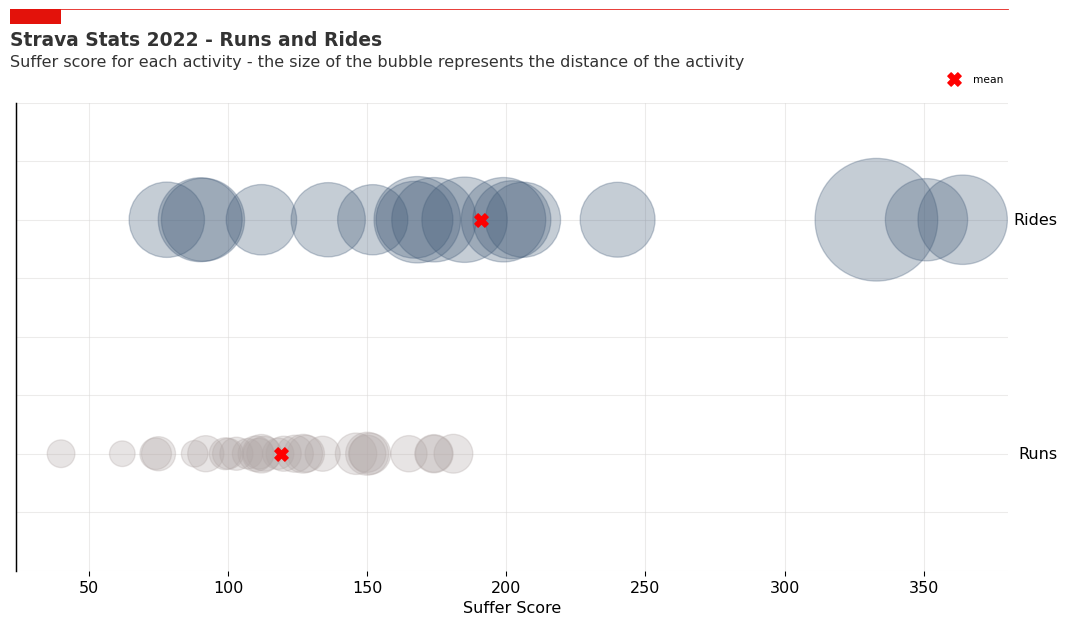

In [998]:
runs_rides = df[(df['sport_type'] == 'Run') | (df['sport_type'] == 'Ride')][['sport_type', 'suffer_score', 'distance', 'moving_time', 'nb_kudos', 'total_elevation_gain', 'average_speed', 'average_heartrate']] 
runs_rides['dummy'] = np.where(runs_rides['sport_type'] == 'Run', 1, 2)
scatter_plot(runs,rides)